In [7]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch

from spenpy.spen import spen


class physical_model:
    def __init__(self, img_size=(96, 96)):
        self.InvA, self.AFinal = spen(acq_point=img_size).get_InvA()

    def __call__(self, x: torch.Tensor, phase_map: torch.Tensor | None = None) -> torch.Tensor:
        # Forward acquisition: A * x, then optional phase on odd lines
        y = torch.matmul(self.AFinal.to(x.device) * 1j, x)
        if phase_map is not None:
            y = y.clone()
            y[:, 1::2, :] *= torch.exp(1j * phase_map)
        return y

    def recons(self, y: torch.Tensor, phase_map: torch.Tensor | None = None) -> torch.Tensor:
        # Inverse: phase correction then A^{-1}
        if phase_map is not None:
            y = y.clone()
            y[:, 1::2, :] *= torch.exp(-1j * phase_map)
        return torch.matmul(self.InvA.to(y.device), y)


log_dir = "/home/data1/musong/workspace/2025/8/08-20/tr/results_test"
input_dir = "/home/data1/musong/workspace/2025/8/08-20/tr/data/IXI_sim"
id = "IXI050-Guys-0711-T1_idx0000"

gt = sio.loadmat(f"{input_dir}/data/{id}.mat")['data']
lr = sio.loadmat(f"{input_dir}/final_rxyacq_ROFFT/{id}.mat")['final_rxyacq_ROFFT']
phase_map = sio.loadmat(f"{input_dir}/phase_map/{id}.mat")['phase_map']
recons = sio.loadmat(f"{log_dir}/{id}_rec.mat")['rec']
phase_pred = sio.loadmat(f"{log_dir}/{id}_phase_pred.mat")['phase_pred']

PM = physical_model()

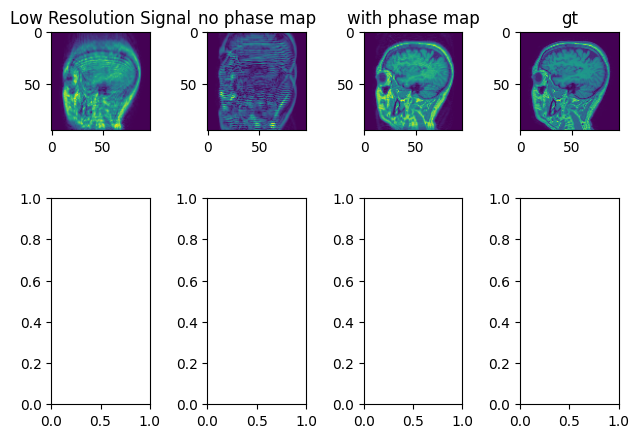

In [8]:
# make it tightlayout
fig, axs = plt.subplots(2, 4)

axs[0, 0].imshow(np.abs(lr))
axs[0, 0].set_title('Low Resolution Signal')

axs[0, 1].imshow(PM.recons(torch.tensor(lr)).abs().numpy())
axs[0, 1].set_title('no phase map')

axs[0, 2].imshow(PM.recons(torch.tensor(lr).unsqueeze(0), torch.tensor(phase_map).unsqueeze(0))[0].abs().numpy())
axs[0, 2].set_title('with phase map')

axs[0, 3].imshow(gt)
axs[0, 3].set_title('gt')

plt.tight_layout()
plt.show()

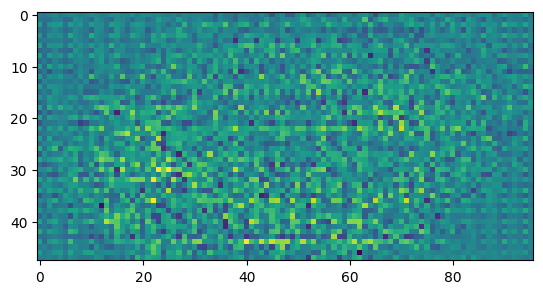

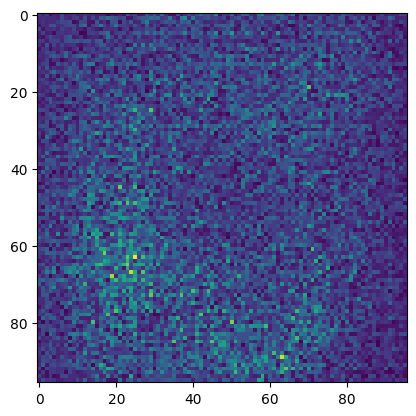

In [19]:
plt.figure()
plt.imshow(phase_pred)

plt.figure()
plt.imshow(np.abs(recons))